In [ ]:
import requests, sys
import pandas as pd
from pathlib import Path
sys.path.append(str(Path('main_prep.ipynb').resolve().parents[1]))
from prep.params import SQLITE_PATH
from prep.sqlitedb import SQLStore

db = SQLStore(SQLITE_PATH)

db.create_video_table()
db.create_frame_table()

db.get_table_names()

### Process single Video and save Images to Frame

In [2]:
# Get all frames from the database
frames = db.fetch_frames()
df_frames = pd.DataFrame(frames, columns=['id', 'video_id', 'frame_index', 'timestamp', 'bs64', 'processed'])
print(f"Total frames fetched: {len(df_frames)}")
df_frames.head()

Total frames fetched: 156


,id,video_id,frame_index,timestamp,bs64,processed
0,21c51a74-766b-4a92-8fde-28aa8437cf23,d138b35c-0de9-47f5-9a32-695d6028154b,12,0.48,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
1,2efaefb8-39e3-49dc-9b58-4c6b65035584,d138b35c-0de9-47f5-9a32-695d6028154b,48,1.92,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
2,9b8f2f16-14b6-499f-a3ae-d85be8fab7a0,d138b35c-0de9-47f5-9a32-695d6028154b,77,3.08,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
3,d483023b-1b21-4a4b-b35c-1805b411ea3c,d138b35c-0de9-47f5-9a32-695d6028154b,128,5.12,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0
4,85e6c126-8dd9-43b3-b853-1e115d313340,d138b35c-0de9-47f5-9a32-695d6028154b,157,6.28,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,0


In [3]:
# Get unprocessed and processed frames (only ids)
unprocessed_frames = db.fetch_unprocessed_frames()
print(f"Total unprocessed frames: {len(unprocessed_frames)}")

# Get processed frames (return only ids)
processed_frames = db.fetch_processed_frames()
print(f"Total processed frames: {len(processed_frames)}")

Total unprocessed frames: 156
Total processed frames: 0


In [4]:
print("Unprocessed Frame IDs:")
for id in unprocessed_frames[:10]:
    print(id)

Unprocessed Frame IDs:
('21c51a74-766b-4a92-8fde-28aa8437cf23',)
('2efaefb8-39e3-49dc-9b58-4c6b65035584',)
('9b8f2f16-14b6-499f-a3ae-d85be8fab7a0',)
('d483023b-1b21-4a4b-b35c-1805b411ea3c',)
('85e6c126-8dd9-43b3-b853-1e115d313340',)
('5d8f0884-0907-46ea-9935-267fc3f2aa3a',)
('10a3102b-6b0a-43b5-b810-aec3feca244c',)
('912de29e-f82e-4119-932c-3467913fb931',)
('548b7853-5f30-4bc1-9814-ec2d4d575151',)
('5e273b7c-b504-4de4-9176-b947df83a97b',)


#### Qdrant

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path('main_prep.ipynb').resolve().parents[1]))
from qdrant_client import QdrantClient, models

QDRANT_PATH = "../data/vectordb/qdrant"
collection_name = "FrameEmbeddings"
VDB = QdrantClient(path=QDRANT_PATH)
VDB.get_collections().collections
# VDB.delete_collection(collection_name)

[CollectionDescription(name='FrameEmbeddings')]

In [6]:
if not VDB.collection_exists(collection_name):
    VDB.create_collection(
        collection_name=collection_name,
        vectors_config={
            "image": models.VectorParams(size=512, distance=models.Distance.COSINE),
            "text": models.VectorParams(size=512, distance=models.Distance.COSINE),
        },
    )
    print(f"Collection '{collection_name}' created successfully.")
else:
    print(f"Collection '{collection_name}' already exists.")

Collection 'FrameEmbeddings' created successfully.


#### Additional Extractions

In [7]:
import numpy as np
from prep.base import Frame
from prep.params import BLIP_DIR, CO_DETR_DIR, CLIP_DIR
from prep.imageProcessing.FrameEmbedding.FrameEmb import ClipEncoder
from prep.imageProcessing.FrameCaptioning.FrameCap import BlipCaptioner
from prep.imageProcessing.ObjectDetection.ObjDetect import ObjectDetector

Cap = BlipCaptioner(BLIP_DIR)
Detector = ObjectDetector(CO_DETR_DIR)
Encoder = ClipEncoder(CLIP_DIR)

for i, id in enumerate(unprocessed_frames):
    print("=" * 20)
    print(f"{i+1}/{len(unprocessed_frames)} --- ID: {id[0]}")
    frame = db.fetch_frame_by_id(id[0])
    F = Frame(frame[0])
    F.video_id = frame[1]
    F.frame_index = frame[2]
    F.timestamp = frame[3]
    F.bs64 = frame[4]
    F.caption = Cap.caption(F.bs64)
    F.objects = set(Detector.detect(F.bs64)['labels'])
    F.cap_embeds = Encoder.text_encode(F.caption)
    F.img_embeds = Encoder.image_encode(F.bs64)

    img_embeds = F.img_embeds
    cap_embeds = F.cap_embeds

    # If they're torch tensors or numpy arrays:
    if hasattr(img_embeds, "tolist"):
        img_embeds = img_embeds.tolist()
    if hasattr(cap_embeds, "tolist"):
        cap_embeds = cap_embeds.tolist()

    # Flatten if accidentally nested
    if isinstance(img_embeds[0], (list, np.ndarray)):
        img_embeds = [float(x) for x in np.array(img_embeds).flatten()]
    if isinstance(cap_embeds[0], (list, np.ndarray)):
        cap_embeds = [float(x) for x in np.array(cap_embeds).flatten()]

    VDB.upsert(
        collection_name=collection_name,
        points=[
            models.PointStruct(
                id=F.id,
                vector={
                    "image": img_embeds,  # Must be 1D list
                    "text": cap_embeds,   # Must be 1D list
                },
                payload={
                    "video_id": F.video_id,
                    "frame_index": F.frame_index,
                    "objects": list(F.objects) if isinstance(F.objects, set) else F.objects,
                    "caption": F.caption,
                }
            )
        ]
    )

    print("Loaded to Qdrant.")
    db.update_frame_processed(F.id, 1)
    print("Marked as processed in the database.")

/Users/dna-tuananguyen/anaconda3/envs/apitcdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


1/156 --- ID: 21c51a74-766b-4a92-8fde-28aa8437cf23
Loaded to Qdrant.
Marked as processed in the database.
2/156 --- ID: 2efaefb8-39e3-49dc-9b58-4c6b65035584
Loaded to Qdrant.
Marked as processed in the database.
3/156 --- ID: 9b8f2f16-14b6-499f-a3ae-d85be8fab7a0
Loaded to Qdrant.
Marked as processed in the database.
4/156 --- ID: d483023b-1b21-4a4b-b35c-1805b411ea3c
Loaded to Qdrant.
Marked as processed in the database.
5/156 --- ID: 85e6c126-8dd9-43b3-b853-1e115d313340
Loaded to Qdrant.
Marked as processed in the database.
6/156 --- ID: 5d8f0884-0907-46ea-9935-267fc3f2aa3a
Loaded to Qdrant.
Marked as processed in the database.
7/156 --- ID: 10a3102b-6b0a-43b5-b810-aec3feca244c
Loaded to Qdrant.
Marked as processed in the database.
8/156 --- ID: 912de29e-f82e-4119-932c-3467913fb931
Loaded to Qdrant.
Marked as processed in the database.
9/156 --- ID: 548b7853-5f30-4bc1-9814-ec2d4d575151
Loaded to Qdrant.
Marked as processed in the database.
10/156 --- ID: 5e273b7c-b504-4de4-9176-b947df8

In [9]:
# Get unprocessed and processed frames (only ids)
unprocessed_frames = db.fetch_unprocessed_frames()
print(f"Total unprocessed frames: {len(unprocessed_frames)}")

# Get processed frames (return only ids)
processed_frames = db.fetch_processed_frames()
print(f"Total processed frames: {len(processed_frames)}")

Total unprocessed frames: 0
Total processed frames: 156


In [1]:
def viz_bs64_image(bs64):
    import numpy as np
    import cv2, base64
    import matplotlib.pyplot as plt

    image_data = base64.b64decode(bs64)
    image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

#### Query w image

In [3]:
import numpy as np
from prep.base import Frame
from prep.params import BLIP_DIR, CO_DETR_DIR, CLIP_DIR
from prep.imageProcessing.FrameEmbedding.FrameEmb import ClipEncoder
from prep.imageProcessing.FrameCaptioning.FrameCap import BlipCaptioner
from prep.imageProcessing.ObjectDetection.ObjDetect import ObjectDetector

Cap = BlipCaptioner(BLIP_DIR)
Detector = ObjectDetector(CO_DETR_DIR)
Encoder = ClipEncoder(CLIP_DIR)

/Users/dna-tuananguyen/anaconda3/envs/apitcdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [16]:
prompt = "A girl is forecasting the weather"
prompt2 = "Cô gái đang dự báo thời tiết"

input_query = Encoder.text_encode(prompt)
input_query=  [float(x) for x in np.array(input_query).flatten()]

In [17]:
img_hits = VDB.query_points(
    collection_name=collection_name,
    query=input_query,
    using="image",
    limit=3,
).points

for hit in img_hits:
    print(hit.id)
    print(hit.vector)
    print(hit.score)
    print(hit.payload)

4178404b-bd03-41e8-b29d-dbfa825ba89e
None
0.3431348050756801
{'video_id': '83cdca21-2bda-42e2-b335-449cafab563d', 'frame_index': 2722, 'objects': ['person'], 'caption': 'a woman in white pants and pink shirt is holding up an ipad'}
921a5820-c116-4ab7-8dba-3bcba9ae77ba
None
0.3337470584591226
{'video_id': '83cdca21-2bda-42e2-b335-449cafab563d', 'frame_index': 926, 'objects': ['person'], 'caption': 'a woman in pink shirt and white pants is holding up an orange object'}
6ba06be6-039c-414c-bf3b-975d84f111e2
None
0.3333238138759708
{'video_id': '83cdca21-2bda-42e2-b335-449cafab563d', 'frame_index': 3041, 'objects': ['cell phone', 'person'], 'caption': 'a woman in a pink shirt and white skirt'}


4178404b-bd03-41e8-b29d-dbfa825ba89e
a woman in white pants and pink shirt is holding up an ipad


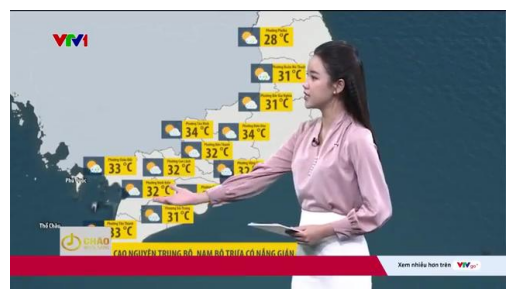

921a5820-c116-4ab7-8dba-3bcba9ae77ba
a woman in pink shirt and white pants is holding up an orange object


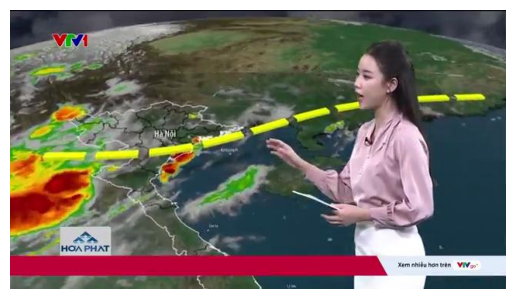

6ba06be6-039c-414c-bf3b-975d84f111e2
a woman in a pink shirt and white skirt


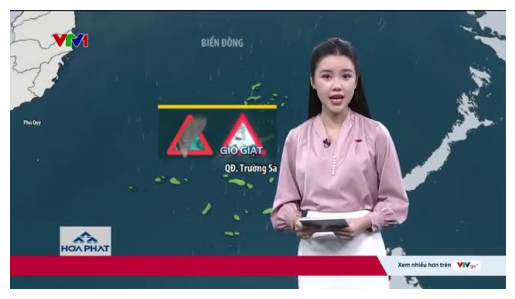

In [18]:
for hit in img_hits:
    print(hit.id)
    print(hit.payload['caption'])
    bs64 = db.fetch_frame_by_id(hit.id)[4]
    viz_bs64_image(bs64)

#### Query w text

c8ae1ca3-3db7-4792-8e07-b04c4cc800d6
a news reporter on tv with an image of the world


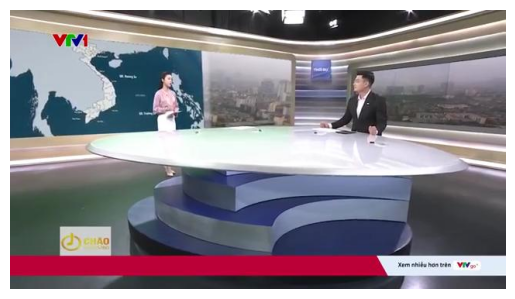

aa2bb50a-f31f-4ccb-8489-653085f4b0f9
a newscast with the news on it


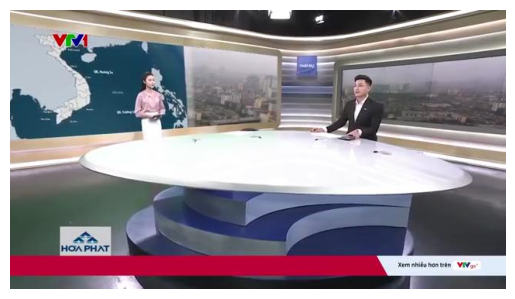

36bfe7e4-def4-4773-90a3-7e27dc8d0065
a man is on the news in a city


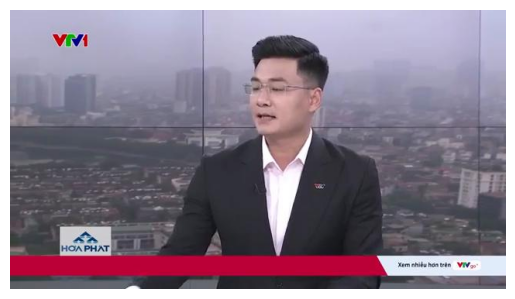

In [19]:
txt_hits = VDB.query_points(
    collection_name=collection_name,
    query=input_query,
    using="text",
    limit=3,
).points

for hit in txt_hits:
    print(hit.id)
    print(hit.payload['caption'])
    bs64 = db.fetch_frame_by_id(hit.id)[4]
    viz_bs64_image(bs64)